In [1]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# from svm_base import SelfAttn
import math
import copy
import sys
from nxt_token_solver import W_svm_solver_cvxpy, R_solver, Tarjan

from utils import * 
from data_utils import * 
from train_utils import train_W, train_Wfin
from visualizer import show_corr, show_norm_diff, show_proj_corr, show_attn_probs, show_attn_probs_neg

# sys.path.insert(1, './..')
from base_nonlinear import MLayerAttn

# score: Random + normalize 
# corr + sofmtax + norm 

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    # Always use the same algorithm to calculate the convolution
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False
set_seed(1)


In [2]:
# Numerical settings
use_double= True

# Optimization options
random_token = True

batch = True

loss_type = 'lsq2' # ['ce', 'nll', 'corr', 'lsq2', 'mse']
token_choice = 'random' # ['equi-corr', 'ortho', 'random']

# Data parameters
"""
cls_choice: corresponds to the classifier assumption
check_acyc: corresponds to the acyclic assumption
check_label: corresponds to the realizable label assumption
rep_seq: set X to be rank-1 sequence
same_last_token: manually set the last token to be the same
"""
separa = False # Whether the last token can map to different labels
use_scc = True 


rep_seq = False
check_label = True
cls_choice = 'gen' # ['gen', 'iden'] # 'iden': identity classifier, 'gen': general classifier
check_asyc = False
same_last_token = False

toy_case = False
batch_toy = False 
custom_initialize = False 


# Model parameters
nlayer = 1 # number of layers

skip = False # add skip connection to every attention output 
layer_norm = False # add layer norm to every attention output
avg_norm = False
factorize_w = False # use W or (Q, K)

initialize_w = 'default' # 'default': random initialization, 'zero': initialize W as zero matrix, 'random': random initialization with varying variance
strong_default = False
initialize_wfin = 'zero'
# reg_wfin = 0 # regularization for W_fin

lr = 0.1

epochs = 10
ITN = 2000

norm_grad = True

n = 6
T = 4
K = 6

dlist = [8] # By setting d = T, the sequence contains all the tokens in the vocabulary without repetition

# dlist = [4, 8, 16]

corr_list = np.zeros((len(dlist), 2, epochs, ITN))
local_corr_list = np.zeros((len(dlist), 2, epochs, ITN))

proj_corr_list = np.zeros((len(dlist), epochs, ITN))
local_proj_corr_list = np.zeros((len(dlist), epochs, ITN))

perp_corr = np.zeros((len(dlist), epochs))
local_perp_corr = np.zeros((len(dlist), epochs))
attn_probs = np.zeros((len(dlist), epochs, ITN))
assert nlayer == 1 
Wi_norm_list = np.zeros((nlayer, epochs, ITN))
Wdiff_norm_list = np.zeros((len(dlist), epochs, ITN))

local_Wdiff_norm_list = np.zeros((len(dlist), epochs, ITN))

Wfin_norm_list = np.zeros((len(dlist), epochs, ITN))
local_Wfin_norm_list = np.zeros((len(dlist), epochs, ITN))
# num_glob1 = np.zeros((len(dlist)))
num_glob = np.zeros((len(dlist)))

cnt_dist = np.zeros((len(dlist), 2))


In [3]:
# for di in range(len(dlist)):
C_thres = 1e-2 # Probability larger than this value will be considered as selected
E_thres = 1e-2 - 1e-3 # Probability between [E_thres, C_thres] is neither considered as selected nor unselected to avoid numerical issues

for di in range(len(dlist)):
    print("Current d: ", dlist[di])
    d = dlist[di]
    for ei in range(epochs):
        # if check_asyc == False:
        #     same_last_token = np.random.randint(2) # Generate the same last token for all the samples to ensure cyclic graph
        if ei % 50 == 0:
            print("Current epoch: ", ei)
        
        flag = False
        # while (not flag):
        # Check the validity of the graph
        print("Sample {}".format(ei))
        X, Vocab, C, dict_token, idx_token = next_data(
            n = n, T = T, K = K, d = d,
            rep_seq = rep_seq, token_choice= token_choice,
            same_last_token = same_last_token, 
            check_label = check_label, check_asyc = check_asyc
        )
        if toy_case:
            X, C, idx_token = manual_toy_case(X, Vocab, idx_token, vary_len = batch_toy)

        print("idx_token", idx_token)

        if custom_initialize:
            if ei == 0:
                const = torch.tensor(10)
            else:
                const = torch.randn(1) * 2
            alphas = [-1.5, 0, 1.5, 0.5, -0.5]
            # alphas = [-2, 2, 1, 0, -1]
            # For local convergence testing
            # alpha1 = [-4, 0, 4, 3, 2, 1, 0,-1,-2,-3] 
            # alpha2 = [-3, 1, 0, -1, 3, 2, 1,0,-1,-2]

            init_w_toy = torch.zeros((d, d)).double()
            for i in range(len(alphas)):
                init_w_toy += Vocab[i].reshape(-1,1) @ Vocab[0].reshape(1,-1) * alphas[i]
            init_w_toy = const.double() * init_w_toy
            print("Margins should be 1, 1, 1, >1, >1")
            # print((Vocab[4] - Vocab[0]).reshape(1, -1) @ init_w_toy @ Vocab[0])
            for i in range(K - 1):
                print("{} - {} margin".format(i, i+1))
                print((Vocab[i] - Vocab[i + 1]).reshape(1, -1) @ init_w_toy @ Vocab[0].reshape( -1, 1))

        if toy_case and batch_toy:
            z = []
            for i in range(len(X)):
                zi = X[i][-1]
                z.append(zi)
            z = torch.stack(z)
            assert z.shape == (n, d)
        else:
            z = X[:, -1].unsqueeze(1) # [n, d]

        idx_z = []
        
        for i in range(n):
            idx_zi = search_key(dict_token, z[i].squeeze())
            idx_z.append(idx_zi)
        idx_z = torch.tensor(idx_z)
        C_alpha = C
        print("C_alpha", C_alpha)
        scc_klst = []
        local_scc_klst = []
        
        if toy_case:
            assert len(set(idx_z)) == len(idx_z), "for toy case we only assuem the same last token"
            for k in range(K):
                if idx_z[0] == k:
                    tarjan_solver = Tarjan(K)
                    tarjan_solver.initialize(idx_token, C_alpha)
                    tarjan_solver.run()
                    scc_lst = tarjan_solver.get_scc()
                    scc_klst.append(scc_lst)
                else:
                    scc_klst.append([])
        else:
            for k in range(K):
                tarjan_solver = Tarjan(K)
                mask = idx_token[:, -1] == k
                cnt = torch.sum(mask).item()
                if cnt == 0:
                    scc_klst.append([])
                    continue
                tarjan_solver.initialize(idx_token[mask], C_alpha[mask])
                tarjan_solver.run()
                scc_lst = tarjan_solver.get_scc()
                scc_klst.append(scc_lst)
        print("SCC ", scc_klst)
        model = MLayerAttn(d, regress = True, n_layer = nlayer, dim_t = T,
                        identity_W=False, identity_V = True, 
                        factorize_W = factorize_w, init = initialize_w,
                        skip = skip, layer_norm = layer_norm, avg_norm = avg_norm,
                ).double()
        # print(model.qklist[0].weight)
        # Copy one model to Wfin
        if strong_default:
            # Initialize Wfin as the same as W
            model_fin = copy.deepcopy(model)
            local_model_fin = copy.deepcopy(model)
        
        # print("Covariance of the weight matrix on initialization: ", torch.cov(model.qklist[0].weight))
        if not custom_initialize:
            print("Using {} initialization".format(initialize_w))
            print("Variance of the weight matrix on initialization: ", torch.var(model.qklist[0].weight))

        parameter_list = [m.weight for m in model.qklist]

        if custom_initialize:
            print("Initialize w manually")
            model.qklist[0].weight.data = init_w_toy
            print("Norm of w on initialization: ", init_w_toy.norm())
        optimizer = torch.optim.SGD(parameter_list, lr=lr, )
        Wi_list = np.zeros((nlayer, ITN, d, d))
        Wfini_list = np.zeros((nlayer, ITN, d, d))
        local_Wfini_list = np.zeros((nlayer, ITN, d, d))
        
        sol_cvx_list = np.zeros((nlayer, 3, d, d))
        local_sol_cvx_list = np.zeros((nlayer, 3, d, d))

        C_lst = [] # Selected tokens
        E_lst = [] # Unselected tokens
 
        model = train_W(
            model, X, idx_token, z, token_choice, cls_choice, Vocab, C_alpha, nlayer,
            n, K, di, ei, ITN, toy_case, batch_toy, scc_klst,
            loss_type, optimizer, norm_grad, parameter_list, 
            Wi_list = Wi_list, attn_probs = attn_probs, Wi_norm_list = Wi_norm_list, 
        )

        # Collect local convergence info 
        for i in range(n):
            mask = torch.nn.functional.one_hot(idx_token[i].unsqueeze(0), num_classes=K).float().permute(0, 2, 1).double()
        
            collapse_prob = (mask @ model.attn[0].permute(0, 2, 1)).squeeze(-1)[i] # [n, K]
            # print("Collapse prob: ", collapse_prob)
            C_lst.append(torch.nonzero(collapse_prob > C_thres, as_tuple= True)[0].tolist())
            collapse_prob[collapse_prob > C_thres] = 0
            E_lst.append(torch.nonzero(collapse_prob > E_thres, as_tuple= True)[0].tolist())
        
        for k in range(K):
            tarjan_solver = Tarjan(K)
            mask = idx_token[:, -1] == k
            cnt = torch.sum(mask).item()
            if cnt == 0:
                local_scc_klst.append([])
                continue
            tarjan_solver.initialize_local(idx_token, C_lst, E_lst, mask)
            tarjan_solver.run()
            scc_lst = tarjan_solver.get_scc()
            local_scc_klst.append(scc_lst)
        
        # cnt_dist = collect_converg(separa, model, cvg_thres, cnt_dist, search_key, dict_token, X, di, C_alpha, loss_type)
        glob_cnt = 0
        for i in range(n): 
            k = idx_token[i, -1]            
            mask = torch.nn.functional.one_hot(idx_token[i].unsqueeze(0), num_classes=K).float().permute(0, 2, 1).double()
            collapse_prob = (mask @ model.attn[0].permute(0, 2, 1)).squeeze(-1) # [n, K]
            # print("Collapse prob: ", collapse_prob)
            collapse_probi =  collapse_prob[i] @ torch.nn.functional.one_hot(torch.tensor(scc_klst[k])).double()
            # print(collapse_probi)
            glob_cnt += collapse_probi[scc_klst[k][C_alpha[i]]].item()
        cnt_dist[di][1] += glob_cnt == n
        cnt_dist[di][0] += 1 - (glob_cnt == n)
        


        if token_choice == 'equi-corr':
            adj_mat = np.zeros((K -1, K - 1, K -1)) # #of distinct last tokens, |ID|, |ID|
        else:
            adj_mat = np.zeros((K , K , K )) # #of distinct last tokens, |ID|, |ID|
            local_adj_mat = np.zeros((K , K, K)) # #of distinct last tokens, |ID|, |ID|
        for i in range(len(idx_token)):
            # Adjacency matrix according to data
            flag_label = False
            for j in range(len(idx_token[i])):
                if idx_token[i][j] == C_alpha[i]:
                    flag_label = True
                    break
            if not flag_label:
                continue
            for j in range(len(idx_token[i])):
                if C_alpha[i] == idx_token[i][j]:
                    continue
                adj_mat[idx_token[i][-1], C_alpha[i], idx_token[i][j]] = 1
        
        for i in range(len(idx_token)):
            # Adjacency matrix according to the W matrix
            for ci in C_lst[i]:
                flag_label = False
                for j in range(len(idx_token[i])):
                    if ci == idx_token[i][j]:
                        flag_label = True
                        break
                if not flag_label:
                    continue
                for j in range(len(idx_token[i])):
                    if ci == idx_token[i][j]:
                        continue
                    
                    if E_lst is not [] and idx_token[i][j] in E_lst[i]:
                        continue
                    # Draw an edge from ci to idx_token[i][j]
                    local_adj_mat[idx_token[i][-1], ci, idx_token[i][j]] = 1
        print("Solving the SVM problem using mm constriants")

        w_dir = W_svm_solver_cvxpy(Vocab, n, d, idx_z, idx_token, C, wfin = False, adj_mat = adj_mat,  scc_lst = scc_klst) 
        w_local_dir = W_svm_solver_cvxpy(Vocab, n, d, idx_z, idx_token, C_lst, wfin = False, adj_mat = local_adj_mat,  scc_lst = local_scc_klst)
        # if toy_case and custom_initialize:
        #         adj_mat_toy = np.copy(adj_mat)
        #         w_dir_toy = W_svm_solver_cvxpy(Vocab, n, T, d, idx_z, C, wfin = False, adj_mat = adj_mat_toy,  W_grad = Wi_list[0, -1], scc_lst = scc_klst) 

        sol_cvx1 = normalize_sol(w_dir)
        sol_cvx_list[0, 1] = sol_cvx1
        
        local_sol_cvx_list[0, 1] = normalize_sol(w_local_dir)
        ####################################
        ##### Calculating W_fin ############
        ####################################

        # if np.isclose(w_dir, np.zeros((d, d))).all():
        #     corr_list[di, 0, ei, :] = np.nan

        red_X, red_idx_token, cyc_X, cyc_idx_token = generate_reduced_ds(X, T, idx_token, C_alpha, scc_klst)
        # red_z = []
        # for i in range(len(red_X)):
        #     red_z.append(red_X[i][:, -1])
        # red_z = torch.cat(red_z, dim = 0).unsqueeze(1)
        if not strong_default:
            model_fin = MLayerAttn(d, regress = True, n_layer = nlayer, dim_t = T,
                            identity_W=False, identity_V = True, 
                            factorize_W = factorize_w, init = initialize_wfin,
                            skip = skip, layer_norm = layer_norm, avg_norm = avg_norm,
                    ).double()
            local_model_fin = MLayerAttn(d, regress = True, n_layer = nlayer, dim_t = T,
                            identity_W=False, identity_V = True, 
                            factorize_W = factorize_w, init = initialize_wfin,
                            skip = skip, layer_norm = layer_norm, avg_norm = avg_norm,
                    ).double()
            
        # print(model_fin.qklist[0].weight)
        # Parameter Initialization 
        parameter_list = [m.weight for m in model_fin.qklist]

        optimizer = torch.optim.SGD(parameter_list, lr=lr)
        empty_X = True
        for i in range(len(red_X)):
            if len(red_X[i]) != 0:
                empty_X = False
                break
        if not empty_X:
            train_Wfin(model_fin, w_dir, red_X, red_idx_token, z, token_choice, cls_choice, Vocab, C_alpha, nlayer, 
                    n, K, di, ei, ITN,
                    loss_type, optimizer, norm_grad, parameter_list, 
                    Wfini_list, perp_corr, local = False
            )

        #########################################
        ##### Calculating local W_fin ###########
        #########################################

        local_red_X, local_red_idx_token, local_cyc_X, local_cyc_idx_token = generate_reduced_ds(X, T, idx_token, C_alpha, local_scc_klst)
        print("Local red idx token: ", local_red_idx_token)
        parameter_list = [m.weight for m in local_model_fin.qklist]

        optimizer = torch.optim.SGD(parameter_list, lr=lr)
        empty_X = True
        for i in range(len(local_red_X)):
            if len(local_red_X[i]) != 0:
                empty_X = False
                break
        if not empty_X:
            train_Wfin(local_model_fin, w_local_dir, local_red_X, local_red_idx_token, z, token_choice, cls_choice, Vocab, C_alpha, nlayer, 
                    n, K, di, ei, ITN,
                    loss_type, optimizer, norm_grad, parameter_list, 
                    local_Wfini_list, local_perp_corr, local = True
            )
        
        # Optimizing R 
        if use_scc:
            R = R_solver(Wi_list, Wfini_list, w_dir)
            local_R = R_solver(Wi_list, local_Wfini_list, w_local_dir)

        if not batch_toy:
            Sfin = cal_Sfin(K, idx_token, red_idx_token, C_alpha, scc_klst, Vocab)
            local_Sfin = cal_Sfin(K, idx_token, local_red_idx_token, C_alpha, local_scc_klst, Vocab)
            
            for it in range(ITN):
                prj_w = project_subspace(Sfin, Wi_list[0, it])
                prj_w_cp = Wi_list[0, it] - prj_w
                proj_corr_list[di, ei, it] = cal_corr(w_dir, prj_w_cp)
                Wdiff_norm_list[di, ei, it] = np.linalg.norm(prj_w - Wfini_list[0, it])
                Wfin_norm_list[di, ei, it] = np.linalg.norm(Wfini_list[0, it])

                local_prj_w = project_subspace(local_Sfin, Wi_list[0, it])
                local_prj_w_cp = Wi_list[0, it] - local_prj_w
                local_proj_corr_list[di, ei, it] = cal_corr(w_local_dir, local_prj_w_cp)
                local_Wdiff_norm_list[di, ei, it] = np.linalg.norm(local_prj_w - local_Wfini_list[0, it])
                local_Wfin_norm_list[di, ei, it] = np.linalg.norm(local_Wfini_list[0, it])
                
                Wi_list[0, it] /= np.linalg.norm(Wi_list[0, it])
                # corr_list[di, 0, ei, it] = Wi_list[0, it].reshape(-1).dot(sol_cvx_list[0, 0].reshape(-1))
                if not separa:
                    # if corr_list[di, 0, ei, it] == 0:
                    corr_list[di, 0, ei, it] = Wi_list[0, it].reshape(-1).dot(sol_cvx_list[0, 1].reshape(-1))
                    corr_list[di, 1, ei, it] = Wi_list[0, it].reshape(-1).dot(normalize_sol(Wfini_list[0, -1] + R * w_dir).reshape(-1))

                    local_corr_list[di, 0, ei, it] = Wi_list[0, it].reshape(-1).dot(local_sol_cvx_list[0, 1].reshape(-1))
                    local_corr_list[di, 1, ei, it] = Wi_list[0, it].reshape(-1).dot(normalize_sol(local_Wfini_list[0, -1] + local_R * w_local_dir).reshape(-1))
                    
                # if it % 100 == 0:
                #     print("Iters {}, Correlation between Wmm and W: {:.4f}".format(it, cal_corr(Wi_list[0, it], w_dir)))
                if it == ITN - 1 and corr_list[di, :, ei, it].max() < 0.95 and np.linalg.norm(w_dir) > 0:
                    print("Global Correlation is too low")
                if it == ITN - 1 and local_corr_list[di, :, ei, it].max() < 0.95 and np.linalg.norm(w_local_dir) > 0:
                    print("Local Correlation is too low")
                    raise Exception("Correlation is too low")
            print("Correlation of W and Wsvm", corr_list[di, 0, ei, -1])
            print("Correlation of W and local Wsvm", local_corr_list[di, 0, ei, -1])
            # print("SCC\n", scc_klst)
    num_glob[di] = num_glob[di] / (epochs)

# print("Number of unsolved sols:", unsol_cnt)

Current d:  8
Current epoch:  0
Sample 0
Generating data
flag_label:  True
flag_asyc:  True
idx_token tensor([[1, 2, 5, 4],
        [5, 0, 1, 2],
        [4, 5, 3, 1],
        [3, 5, 0, 2],
        [3, 1, 0, 4],
        [5, 1, 3, 0]])
C_alpha tensor([1, 5, 5, 0, 1, 3])
SCC  [[0, 1, 2, 4, 5, 3], [0, 1, 2, 3, 4, 5], [3, 1, 0, 2, 4, 3], [], [0, 5, 4, 2, 1, 3], []]
Using default initialization
Variance of the weight matrix on initialization:  tensor(0.0415, dtype=torch.float64, grad_fn=<VarBackward0>)
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 0, Loss: 0.6716
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 500, Loss: 0.4546
Norm of grad:  tensor(0.1826, dtype=torch.float64)
Current iteration: 1000, Loss: 0.4546
Norm of grad:  tensor(0.0459, dtype=torch.float64)
Current iteration: 1500, Loss: 0.4546
Solving the SVM problem using mm constriants
Time for constraints: 0.0007989406585693359
Number of constraints: 5
Solving problems
Solved
First s

In [4]:
print("Global Correlation")
for ii in range(corr_list.shape[1]):
    print(corr_list[0, ii, :, -1])
print(proj_corr_list[0, :, -1])

print("Local Correlation")
for ii in range(corr_list.shape[1]):
    print(local_corr_list[0, ii, :, -1])

print(perp_corr.max())
print(local_perp_corr.max())

Global Correlation
[0.26379102 0.747186   0.50562599 0.78473453 0.82797967 0.94877882
 0.93374448 0.41001696 0.5195011  0.52117378]
[0.39981872 0.73637398 0.39802037 0.96829483 0.93680141 0.97776717
 0.96059174 0.57945975 0.02793158 0.5589314 ]
[0.27555242 0.78356897 0.51605233 0.94773956 0.93132346 0.97262178
 0.95611379 0.46672828 0.7201225  0.53127658]
Local Correlation
[0.99887992 0.99209596 0.99952876 0.9970317  0.99857763 0.99940865
 0.99917508 0.99583999 0.99928289 0.99951486]
[0.99887993 0.99209596 0.99952876 0.99703171 0.99857763 0.99940866
 0.99917508 0.99584    0.99928289 0.99951486]
0.01444677958438649
0.0


--------Section 1 correlation between Wgd and Wsvm sols--------
Only shows Wmm


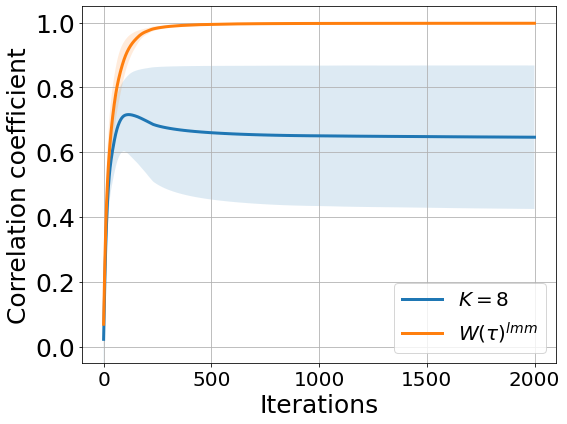

--------Section 2 norm difference between Wgd and Wsvm sols--------


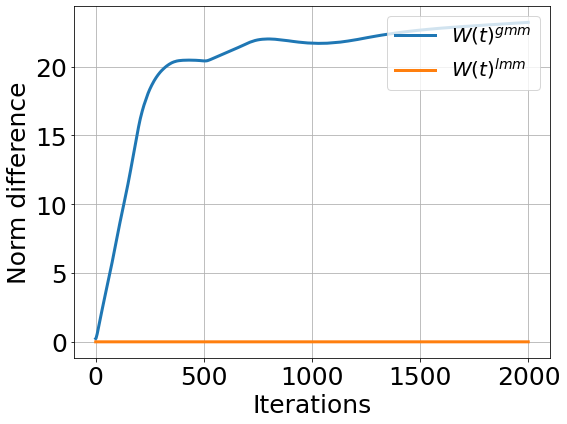

--------Section 3 projected correlation between proj_Sfin(Wgd) and Wfin sols--------


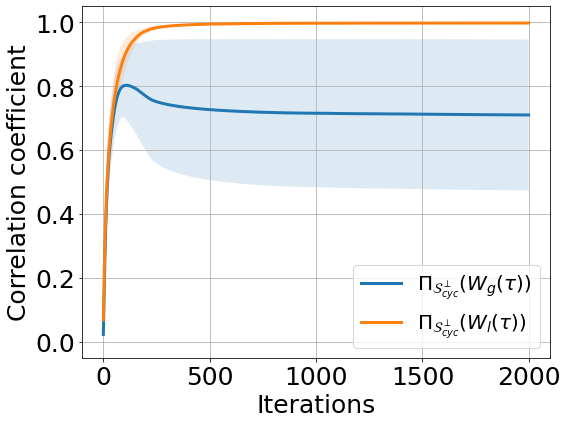

--------Section 4 attn probs--------


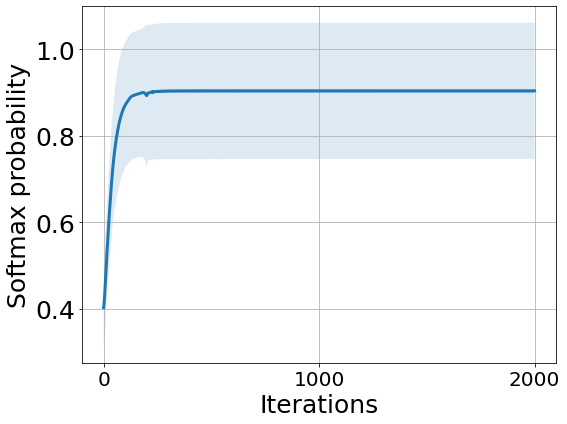

--------Section 5 attn probs (-log)--------


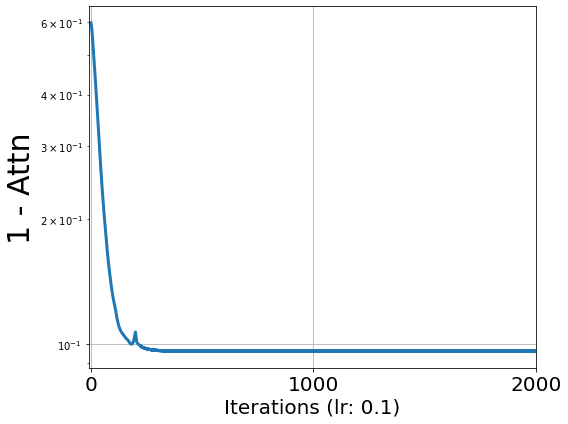

In [5]:
print("-"*8 + "Section 1 correlation between Wgd and Wsvm sols"+"-"*8)
show_corr(ITN, dlist, corr_list, wmm = True, local_corr_list = local_corr_list)
# show_corr(ITN, dlist, corr_list, wmm = False, local_corr_list = local_corr_list)

print("-"*8 + "Section 2 norm difference between Wgd and Wsvm sols"+"-"*8)
show_norm_diff(ITN, dlist, Wdiff_norm_list, local_Wdiff_norm_list = local_Wdiff_norm_list, use_square = False)

print("-"*8 + "Section 3 projected correlation between proj_Sfin(Wgd) and Wfin sols"+"-"*8)
show_proj_corr(ITN, dlist, proj_corr_list, local_proj_corr_list)

print("-"*8 + "Section 4 attn probs"+"-"*8)
show_attn_probs(ITN, attn_probs, 0, lr)

print("-"*8 + "Section 5 attn probs (-log)"+"-"*8)
show_attn_probs_neg(ITN, attn_probs, 0, lr)